In [1]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, TensorDataset

%matplotlib inline
sys.path.append('/workspace/inkyung/Fall_Detection_using_multihorizon_forecasting/')

In [2]:
np.random.seed(42)
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
data_dir = '../dataset/dlr_preprocessed/'
train = pd.read_csv(data_dir + 'train.csv', index_col=0)
valid = pd.read_csv(data_dir + 'valid.csv', index_col=0)
test = pd.read_csv(data_dir + 'test.csv', index_col=0)

/opt/conda/envs/inkyung_tft/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
train.head()

,time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,labels,per_name,per_idx,per_age,per_height,per_gender
0,17.15,-9.702358,0.020635,1.674165,0.013820,-0.013123,0.016836,1.273326,0.392144,0.312653,STNDING,Korbinian,8,29.0,1.65,Male
1,17.16,-9.707232,0.025566,1.666926,0.004869,-0.003397,0.015052,1.267351,0.391066,0.307638,STNDING,Korbinian,8,29.0,1.65,Male
2,17.17,-9.702337,0.011063,1.664216,-0.014894,-0.007078,0.016662,1.270401,0.394067,0.311236,STNDING,Korbinian,8,29.0,1.65,Male
3,17.18,-9.692591,0.020641,1.671842,-0.007739,-0.015927,0.018439,1.270320,0.389785,0.311519,STNDING,Korbinian,8,29.0,1.65,Male
4,17.19,-9.680356,-0.003477,1.661697,-0.005921,0.001813,0.018580,1.271230,0.391007,0.312000,STNDING,Korbinian,8,29.0,1.65,Male


In [5]:
activity_info = ['FALLING', 'JUMPING', 'RUNNING', 'SITTING', 'STNDING', 'TRANSDW', 'TRANSUP', 'TRNSACC', 'TRNSDCC', 'WALKING', 'XLYINGX']

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(activity_info)

train_encoded = encoder.transform(train['labels'])
train['label_encoded'] = train_encoded

valid_encoded = encoder.transform(valid['labels'])
valid['label_encoded'] = valid_encoded

test_encoded = encoder.transform(test['labels'])
test['label_encoded'] = test_encoded

In [7]:
valid.head()

,time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z,labels,per_name,per_idx,per_age,per_height,per_gender,label_encoded
0,13.49,-9.420184,1.458564,2.357733,-0.009265,-0.008148,0.012368,1.100023,-0.140067,-0.699308,STNDING,Christine,5,52.0,1.64,Female,4
1,13.50,-9.447023,1.444128,2.354667,-0.002922,-0.002704,0.006194,1.107744,-0.140104,-0.701840,STNDING,Christine,5,52.0,1.64,Female,4
2,13.51,-9.451902,1.444166,2.352181,-0.000207,0.011504,0.005428,1.099453,-0.140534,-0.696114,STNDING,Christine,5,52.0,1.64,Female,4
3,13.52,-9.459247,1.465909,2.357463,-0.003803,-0.004444,0.003493,1.106179,-0.143121,-0.698918,STNDING,Christine,5,52.0,1.64,Female,4
4,13.53,-9.437350,1.477480,2.401761,0.006994,0.008050,0.001872,1.099500,-0.141625,-0.697040,STNDING,Christine,5,52.0,1.64,Female,4


In [8]:
train_obs_scaler = StandardScaler()
train_tar_scaler = StandardScaler()

test_obs_scaler = StandardScaler()
test_tar_scaler = StandardScaler()

columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z','label', 'per_idx']

obs_train = train[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
obs_train = train_obs_scaler.fit_transform(obs_train)
tar_train = np.asarray(train['label_encoded'])
tar_train = train_tar_scaler.fit_transform(tar_train.reshape(-1, 1))

obs_train = pd.DataFrame(obs_train)
tar_train = pd.DataFrame(tar_train)
transformed_train = pd.concat([obs_train, tar_train], axis=1)
transformed_train['per_idx'] = train['per_idx'].values
transformed_train.columns = columns
transformed_train.head()

obs_valid = valid[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
obs_valid = train_obs_scaler.fit_transform(obs_valid)
tar_valid = np.asarray(valid['label_encoded'])
tar_valid = train_tar_scaler.fit_transform(tar_valid.reshape(-1, 1))

obs_valid = pd.DataFrame(obs_valid)
tar_valid = pd.DataFrame(tar_valid)
transformed_valid = pd.concat([obs_valid, tar_valid], axis=1)
transformed_valid['per_idx'] = valid['per_idx'].values
transformed_valid.columns = columns
# transformed_valid.head()

obs_test = test[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']]
obs_test = test_obs_scaler.fit_transform(obs_test)
tar_test = np.asarray(test['label_encoded'])
tar_test = test_tar_scaler.fit_transform(tar_test.reshape(-1, 1))

obs_test = pd.DataFrame(obs_test)
tar_test = pd.DataFrame(tar_test)
transformed_test = pd.concat([obs_test, tar_test], axis=1)
transformed_test['per_idx'] = test['per_idx'].values
transformed_test.columns = columns
transformed_test.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label,per_idx
0,-0.068564,-0.706866,0.021258,0.003836,-0.013402,0.012842,-0.723538,2
1,-0.069641,-0.704326,0.018191,-0.011038,0.003577,0.008124,-0.723538,2
2,-0.068559,-0.711797,0.017042,-0.043876,-0.002850,0.012381,-0.723538,2
3,-0.066406,-0.706863,0.020274,-0.031988,-0.018298,0.017080,-0.723538,2
4,-0.063703,-0.719287,0.015975,-0.028967,0.012671,0.017453,-0.723538,2


# Data processing

In [9]:
def dataProcessing(data):
    X_data, y_data = list(), list()
    for i in range(100, len(data) - 100):
        acc_x = data['acc_x'][i-100: i]
        acc_y = data['acc_y'][i-100: i]
        acc_z = data['acc_z'][i-100: i]
        gyro_x = data['gyro_x'][i-100: i]
        gyro_y = data['gyro_y'][i-100: i]
        gyro_z = data['gyro_z'][i-100: i]
        X_data.append([acc_x.values, acc_y.values, acc_z.values, gyro_x.values, gyro_y.values, gyro_z.values])
        
        outcome = data['label'][i: i+100]
        y_data.append([outcome.values])
    return X_data, y_data

In [10]:
X_train, y_train = dataProcessing(transformed_train)
X_valid, y_valid = dataProcessing(transformed_valid)
X_test, y_test = dataProcessing(transformed_test)

In [15]:
batch_size = 128

train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

valid_data = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# Model

In [16]:
from model.CNN import CNN
from model.LSTM import LSTM

In [17]:
def choose_model(model_type):
    if model_type == 'SingleLSTM':
        model = LSTM(6, 320, 100, 1).to(device)
        save_path = '../results/singleLSTM/'
    elif model_type == 'StackedLSTM':
        model = LSTM(6, 320, 100, 2).to(device)
        save_path = '../results/stackedLSTM/'
    elif model_type == 'CNN':
        model = CNN(6, [80, 160, 320], 100).to(device)
        save_path = '../results/CNN/'
    save_file_name = save_path + f'{model_type}DLR.pth'
    return model, save_path, save_file_name

In [42]:
model_type = 'SingleLSTM'
model, save_path, save_file_name = choose_model(model_type)
print(model)

LSTM(
  (lstm): LSTM(6, 320, batch_first=True)
  (bn): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=320, out_features=100, bias=True)
)


In [19]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       mode='min',
                                                       factor=0.2
                                                    )
criterion = nn.MSELoss().to(device)
patience = 5
n_epochs = 300

In [18]:
# example

with torch.no_grad():
    dataiter = iter(train_loader)
    X, y = dataiter.next()
    
    ex_model = model
    if model_type != 'CNN':
        X = X.view(-1, 100, 6)
    print('X size', X.shape)
    print('y size', y.shape)
    output = ex_model(X.to(device))
    print(output.shape)

X size torch.Size([128, 100, 6])
y size torch.Size([128, 1, 100])
torch.Size([128, 100])


In [19]:
def fit(model, batch_size, n_epochs, save_file_name):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    best_loss = 9999999999
    patience = 0
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            if model_type != 'CNN':
                data, target = data.view(-1, 100, 6).to(device), target.to(device)
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            if model_type != 'CNN':
                loss = criterion(output, target.squeeze())
            else:
                loss = criterion(output.squeeze(), target.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            if model_type != 'CNN':
                data, target = data.view(-1, 100, 6).to(device), target.to(device)
            else:
                data, target = data.to(device), target.to(device)
            output = model(data.cuda())
            if model_type != 'CNN':
                loss = criterion(output, target.squeeze())
            else:
                loss = criterion(output.squeeze(), target.squeeze())
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
            
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = 0
            torch.save(model.state_dict(), save_file_name)
            print('Saving Model')
        else:
            patience += 1
            print('Patience for ', patience)
        if patience == 10:
            break

    model.load_state_dict(torch.load(save_file_name))

    return  model, avg_train_losses, avg_valid_losses

In [20]:
model, train_loss, valid_loss = fit(model, batch_size, n_epochs, save_file_name)

[  1/300] train_loss: 1.00541 valid_loss: 1.01342
Saving Model
[  2/300] train_loss: 1.00467 valid_loss: 1.00201
Saving Model
[  3/300] train_loss: 1.00434 valid_loss: 1.00075
Saving Model
[  4/300] train_loss: 1.00401 valid_loss: 1.00081
Patience for  1
[  5/300] train_loss: 1.00399 valid_loss: 1.00119
Patience for  2
[  6/300] train_loss: 1.00417 valid_loss: 1.00364
Patience for  3
[  7/300] train_loss: 1.00401 valid_loss: 1.00889
Patience for  4
[  8/300] train_loss: 1.00427 valid_loss: 1.01300
Patience for  5
[  9/300] train_loss: 1.00409 valid_loss: 1.01191
Patience for  6
[ 10/300] train_loss: 1.00449 valid_loss: 1.01787
Patience for  7
[ 11/300] train_loss: 1.00412 valid_loss: 1.03248
Patience for  8
[ 12/300] train_loss: 1.00418 valid_loss: 1.03052
Patience for  9
[ 13/300] train_loss: 1.00401 valid_loss: 1.04905
Patience for  10


In [20]:
def evaluate_model(model, test_loader):
    test_loss = 0.0
    y_test = []
    y_hat = []
    model.eval()
    for data,target in test_loader:
        if model_type != 'CNN':
            data, target = data.view(-1, 100, 6).cuda(), target.cuda()
        else:
            data, target = data.cuda(), target.cuda()   
        output = model(data.cuda())
        loss = criterion(output.squeeze(), target.squeeze())
        test_loss += loss.item()
        y_test += list(target.squeeze().detach().cpu().numpy())
        y_hat += list(output.squeeze().detach().cpu().numpy())
        
    return test_loss/len(test_loader), y_test, y_hat

In [43]:
model.load_state_dict(torch.load(save_file_name))

<All keys matched successfully>

In [44]:
test_loss, y_target, y_hat = evaluate_model(model, test_loader)

In [23]:
y_target[:5], y_hat[:5]

([-0.72353786, -0.72353786, -0.72353786, -0.72353786, -0.72353786],
 [-0.016381964, -0.016881041, -0.017291809, -0.025133757, -0.034871675])

In [45]:
labels = test_tar_scaler.inverse_transform(np.asarray(y_target).reshape(-1, 1))
predicted = test_tar_scaler.inverse_transform(np.asarray(y_hat).reshape(-1, 1))

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def getScores(forecast, target):
    forecasted, transformed_target = list(), list()

    for v in forecast:
        if v < 10.5 and v >= 9.5:
            forecasted.append(10.0)
        elif v < 9.5 and v >= 8.5:
            forecasted.append(9.0)
        elif v < 8.5 and v >= 7.5:
            forecasted.append(8.0)
        elif v < 7.5 and v >= 6.5:
            forecasted.append(7.0)
        elif v < 6.5 and v >= 5.5:
            forecasted.append(6.0)
        elif v < 5.5 and v >= 4.5:
            forecasted.append(5.0)
        elif v < 4.5 and v >= 3.5:
            forecasted.append(4.0)
        elif v < 3.5 and v >= 2.5:
            forecasted.append(2.0)
        elif v < 2.5 and v >= 1.5:
            forecasted.append(2.0)
        elif v < 1.5 and v >= 0.5:
            forecasted.append(0.0)
        elif v < 0.5 and v >= -.5:
            forecasted.append(0.0)
                
    for v in target:
        if v < 10.5 and v >= 9.5:
            transformed_target.append(10.0)
        elif v < 9.5 and v >= 8.5:
            transformed_target.append(9.0)
        elif v < 8.5 and v >= 7.5:
            transformed_target.append(8.0)
        elif v < 7.5 and v >= 6.5:
            transformed_target.append(7.0)
        elif v < 6.5 and v >= 5.5:
            transformed_target.append(6.0)
        elif v < 5.5 and v >= 4.5:
            transformed_target.append(5.0)
        elif v < 4.5 and v >= 3.5:
            transformed_target.append(4.0)
        elif v < 3.5 and v >= 2.5:
            transformed_target.append(2.0)
        elif v < 2.5 and v >= 1.5:
            transformed_target.append(2.0)
        elif v < 1.5 and v >= 0.5:
            transformed_target.append(0.0)
        elif v < 0.5 and v >= -.5:
            transformed_target.append(0.0)
    
    recall = recall_score(transformed_target, forecasted, average='micro')
    precision = precision_score(transformed_target, forecasted, average='micro')
    f1 = f1_score(transformed_target, forecasted, average='micro')
    acc = accuracy_score(transformed_target, forecasted)
    
    return acc, precision, recall, f1

In [ ]:
acc, precision, recall, f1 = getScores(predicted, labels)

In [26]:
corrected_labels = []
for i in range(len(labels)):
    if labels[i] != 1.0:
        corrected_labels.append(0.0)
    else:
        corrected_labels.append(1.0)

In [27]:
from collections import Counter
cnt_y_hat = Counter(predicted)

thres = np.array(list(cnt_y_hat.keys())).mean()
corrected_predicted = []
for i in range(len(predicted)):
    if predicted[i] < thres:
        corrected_predicted.append(0.0)
    else:
        corrected_predicted.append(1.0)

In [28]:
print(confusion_matrix(corrected_labels, corrected_predicted))
print()
acc = accuracy_score(corrected_labels, corrected_predicted)
f1 = f1_score(corrected_labels, corrected_predicted)
recall = recall_score(corrected_labels, corrected_predicted)
precision = precision_score(corrected_labels, corrected_predicted)

print('recall score is ', recall)
print('precision score is ', precision)
print('f1 score is ', f1)
print('accuracy score is ', acc)

[[26890989 31286611]
 [ 1242914   543986]]



KeyboardInterrupt: 

In [ ]:
result = pd.DataFrame([acc, precision, recall, f1]).T
result.columns = ['Accuracy', 'Precision', 'Recall', 'F1']
result.to_csv(save_path + 'SingleLSTMDLR.csv')

In [46]:
labels_100, predicted_100 = list(), list()
for i in range(len(labels)):
    if i % 100 == 0:
        labels_100.append(labels[i])
for i in range(len(predicted)):
    if i % 100 == 0:
        predicted_100.append(predicted[i])

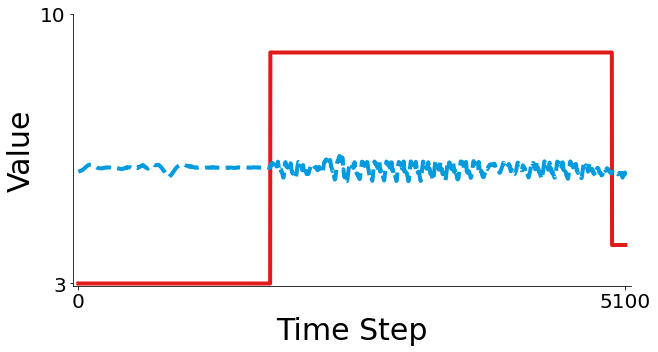

<Figure size 432x288 with 0 Axes>

In [47]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.margins(x=0.01, y=0.01)
plt.plot(labels_100[3000:8100], label='target', color='#E31A1C', linewidth=4)
plt.plot(predicted_100[3000:8100], label='predicted', color='#009ADE', linestyle='--', linewidth=4)
plt.xticks([0, 5100], fontsize=20)
plt.yticks([3, 10], fontsize=20)
plt.xlabel('Time Step', fontsize=30)
plt.ylabel('Value', fontsize=30)
plt.show()
plt.savefig(save_path + f'{model_type}DLR.png')